# 在 PyTorch 中训练您的模型
## 简介
在之前的视频中，我们已经讨论并演示了：
* 使用 torch.nn 模块的神经网络层和函数构建模型
* 自动梯度计算的机制，这是基于梯度的模型训练的核心
* 使用 TensorBoard 可视化训练进度和其他活动

在本视频中，我们将为您的工具库添加一些新工具：
* 我们将熟悉数据集和数据加载器抽象，以及它们如何简化在训练循环中向模型提供数据的过程
* 我们将讨论特定的损失函数以及何时使用它们
* 我们将了解 PyTorch 优化器，它实现了根据损失函数的结果调整模型权重的算法

最后，我们将把这些工具结合起来，看看完整的 PyTorch 训练循环是如何运行的。

## 数据集和数据加载器

`Dataset` 和 `DataLoader` 类封装了从存储中提取数据并以批量形式将其暴露给训练循环的过程。

`Dataset` 负责访问和处理单个数据实例。

`DataLoader` 从 `Dataset` 中提取数据实例（可以自动或使用您定义的采样器），将它们收集成批量，并返回供训练循环使用。`DataLoader` 可以处理各种类型的数据集，无论它们包含何种类型的数据。

在本教程中，我们将使用 TorchVision 提供的 Fashion-MNIST 数据集。我们使用 `torchvision.transforms.Normalize()` 对图像内容进行零中心化和归一化，并下载训练和验证数据集。

In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms

# PyTorch TensorBoard 支持
from torch.utils.tensorboard import SummaryWriter
from datetime import datetime


transform = transforms.Compose(
    [transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))])  # 归一化图像数据

# 创建训练和验证数据集，如有必要则下载
training_set = torchvision.datasets.FashionMNIST('./data', train=True, transform=transform, download=True)
validation_set = torchvision.datasets.FashionMNIST('./data', train=False, transform=transform, download=True)

# 为数据集创建数据加载器；训练数据需要打乱，验证数据不需要
training_loader = torch.utils.data.DataLoader(training_set, batch_size=4, shuffle=True, num_workers=2)
validation_loader = torch.utils.data.DataLoader(validation_set, batch_size=4, shuffle=False, num_workers=2)

# 类别标签
classes = ('T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
        'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle Boot')

# 报告数据集大小
print('训练集包含 {} 个实例'.format(len(training_set)))
print('验证集包含 {} 个实例'.format(len(validation_set)))

Training set has 60000 instances
Validation set has 10000 instances


和往常一样，让我们可视化数据以进行合理性检查：

Sandal  Shirt  Shirt  Sandal


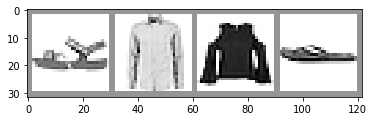

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# 用于内联显示图像的辅助函数
def matplotlib_imshow(img, one_channel=False):
    if one_channel:
        img = img.mean(dim=0)
    img = img / 2 + 0.5     # 反归一化
    npimg = img.numpy()
    if one_channel:
        plt.imshow(npimg, cmap="Greys")
    else:
        plt.imshow(np.transpose(npimg, (1, 2, 0)))

dataiter = iter(training_loader)
images, labels = dataiter.next()

# 从图像创建网格并显示
img_grid = torchvision.utils.make_grid(images)
matplotlib_imshow(img_grid, one_channel=True)
print('  '.join(classes[labels[j]] for j in range(4)))  # 打印图像对应的类别标签

## 模型

在本示例中，我们将使用 LeNet-5 的一个变体模型——如果您观看过本系列的前几期视频，这应该很熟悉。

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

# PyTorch 模型继承自 torch.nn.Module
class GarmentClassifier(nn.Module):
    def __init__(self):
        super(GarmentClassifier, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 4 * 4, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 4 * 4)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x
    

model = GarmentClassifier()

## 损失函数

在本示例中，我们将使用交叉熵损失。为了演示，我们将创建虚拟输出和标签值的批次，通过损失函数运行它们，并检查结果。

In [ ]:
loss_fn = torch.nn.CrossEntropyLoss()

# 注意：损失函数期望数据以批次形式提供，因此我们创建了 4 个批次
# 表示模型对每个输入在 10 个类别中的置信度
dummy_outputs = torch.rand(4, 10)
# 表示测试的 10 个类别中的正确类别
dummy_labels = torch.tensor([1, 5, 3, 7])
    
print(dummy_outputs)
print(dummy_labels)

loss = loss_fn(dummy_outputs, dummy_labels)
print('此批次的总损失：{}'.format(loss.item()))

tensor([[0.7915, 0.4766, 0.3735, 0.5340, 0.0799, 0.9948, 0.1870, 0.0507, 0.1183,
         0.9106],
        [0.9666, 0.3765, 0.4324, 0.7354, 0.1953, 0.8906, 0.6882, 0.1925, 0.7076,
         0.8777],
        [0.4412, 0.0325, 0.4886, 0.9350, 0.9792, 0.5580, 0.6199, 0.2478, 0.3619,
         0.8307],
        [0.3287, 0.8571, 0.6046, 0.6719, 0.5982, 0.0540, 0.7193, 0.4764, 0.7451,
         0.8345]])
tensor([1, 5, 3, 7])
Total loss for this batch: 2.196722984313965


## 优化器

在本示例中，我们将使用简单的[随机梯度下降](https://pytorch.org/docs/stable/optim.html)（带动量）。

尝试一些优化方案的变化可能会很有启发：
* 学习率决定了优化器采取的步长大小。不同的学习率对训练结果有什么影响，包括准确性和收敛时间？
* 动量在多个步骤中将优化器推向最强梯度的方向。改变这个值对结果有什么影响？
* 尝试一些不同的优化算法，例如平均 SGD、Adagrad 或 Adam。结果有何不同？

In [ ]:
# 优化器在 torch.optim 包中指定
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

## 训练循环

下面是一个执行一个训练周期的函数。它枚举来自 DataLoader 的数据，并在每次循环中执行以下操作：
* 从 DataLoader 获取一批训练数据
* 清零优化器的梯度
* 执行推理——即从模型获取输入批次的预测
* 计算该组预测与数据集标签之间的损失
* 计算学习权重的反向梯度
* 告诉优化器执行一个学习步骤——即根据该批次的观察梯度调整模型的学习权重，按照我们选择的优化算法
* 每 1000 个批次报告一次损失。
* 最后，报告最后 1000 个批次的平均每批次损失，以便与验证运行进行比较

In [ ]:
def train_one_epoch(epoch_index, tb_writer):
    running_loss = 0.
    last_loss = 0.
    
    # 在这里，我们使用 enumerate(training_loader) 而不是
    # iter(training_loader)，以便跟踪批次索引并进行一些周期内报告
    for i, data in enumerate(training_loader):
        # 每个数据实例都是一个输入 + 标签对
        inputs, labels = data
        
        # 每批次清零梯度！
        optimizer.zero_grad()
        
        # 为此批次进行预测
        outputs = model(inputs)
        
        # 计算损失及其梯度
        loss = loss_fn(outputs, labels)
        loss.backward()
        
        # 调整学习权重
        optimizer.step()
        
        # 收集数据并报告
        running_loss += loss.item()
        if i % 1000 == 999:
            last_loss = running_loss / 1000 # 每批次损失
            print('  批次 {} 损失：{}'.format(i + 1, last_loss))
            tb_x = epoch_index * len(training_loader) + i + 1
            tb_writer.add_scalar('Loss/train', last_loss, tb_x)
            running_loss = 0.
            
    return last_loss

### 每周期活动

每个周期我们需要做一些事情：
* 通过检查未用于训练的数据集上的相对损失进行验证，并报告结果
* 保存模型的副本

在这里，我们将在 TensorBoard 中进行报告。这需要转到命令行启动 TensorBoard，并在另一个浏览器标签中打开它。

In [ ]:
# 在单独的单元中初始化，以便轻松向同一运行添加更多周期
timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
writer = SummaryWriter('runs/fashion_trainer_{}'.format(timestamp))
epoch_number = 0

In [ ]:
EPOCHS = 5

best_vloss = 1_000_000.

for epoch in range(EPOCHS):
    print('周期 {}:'.format(epoch_number + 1))
    
    # 确保梯度跟踪已打开，并对数据进行一次遍历
    model.train(True)
    avg_loss = train_one_epoch(epoch_number, writer)
    
    # 我们不需要梯度来进行报告
    model.train(False)
    
    running_vloss = 0.0
    for i, vdata in enumerate(validation_loader):
        vinputs, vlabels = vdata
        voutputs = model(vinputs)
        vloss = loss_fn(voutputs, vlabels)
        running_vloss += vloss
    
    avg_vloss = running_vloss / (i + 1)
    print('损失 训练 {} 验证 {}'.format(avg_loss, avg_vloss))
    
    # 记录每批次平均损失
    # 包括训练和验证
    writer.add_scalars('Training vs. Validation Loss',
                    { 'Training' : avg_loss, 'Validation' : avg_vloss },
                    epoch_number + 1)
    writer.flush()
    
    # 跟踪最佳性能，并保存模型状态
    if avg_vloss < best_vloss:
        best_vloss = avg_vloss
        model_path = 'model_{}_{}'.format(timestamp, epoch_number)
        torch.save(model.state_dict(), model_path)
    
    epoch_number += 1

EPOCH 6:
  batch 1000 loss: 0.2712569512435075
  batch 2000 loss: 0.2601859306513652
  batch 3000 loss: 0.259985514376438
  batch 4000 loss: 0.2620664734886377
  batch 5000 loss: 0.25726098109555096
  batch 6000 loss: 0.2829849383759356
  batch 7000 loss: 0.2504337926213739
  batch 8000 loss: 0.28633546594417153
  batch 9000 loss: 0.2615796004622789
  batch 10000 loss: 0.27075869734541264
  batch 11000 loss: 0.26998766335008256
  batch 12000 loss: 0.2614513303764511
  batch 13000 loss: 0.25101113697645633
  batch 14000 loss: 0.2572545314691452
  batch 15000 loss: 0.2646196218387686
LOSS train 0.2646196218387686 valid 0.3120253086090088
EPOCH 7:
  batch 1000 loss: 0.23217408991576668
  batch 2000 loss: 0.26750317257382084
  batch 3000 loss: 0.2423647686961576
  batch 4000 loss: 0.247761928711403
  batch 5000 loss: 0.2550650118602407
  batch 6000 loss: 0.2383200812106561
  batch 7000 loss: 0.24519096856425546
  batch 8000 loss: 0.26013731523246864
  batch 9000 loss: 0.2632041203577719
  

要加载模型的保存版本：

```
saved_model = GarmentClassifier()
saved_model.load_state_dict(torch.load(PATH))
```

加载模型后，它可以用于任何您需要的任务——进一步训练、推理或分析。

请注意，如果您的模型具有影响模型结构的构造参数，则需要提供这些参数并以与保存时相同的方式配置模型。

## 其他资源

* [数据工具](https://pytorch.org/docs/stable/data.html) 的文档，包括 Dataset 和 DataLoader，位于 pytorch.org
* 关于 [固定内存的使用](https://pytorch.org/docs/stable/notes/cuda.html#cuda-memory-pinning) 的说明，用于 GPU 训练
* [TorchVision](https://pytorch.org/docs/stable/torchvision/datasets.html)、[TorchText](https://pytorch.org/text/datasets.html) 和 [TorchAudio](https://pytorch.org/audio/datasets.html) 中可用数据集的文档
* PyTorch 中可用的 [损失函数](https://pytorch.org/docs/stable/nn.html#loss-functions) 的文档
* [torch.optim 包](https://pytorch.org/docs/stable/optim.html) 的文档，其中包括优化器和相关工具，例如学习率调度
* 关于保存和加载模型的详细 [教程](https://pytorch.org/tutorials/beginner/saving_loading_models.html)
* [pytorch.org 的教程部分](https://pytorch.org/tutorials/) 包含关于各种训练任务的教程，包括不同领域的分类、生成对抗网络、强化学习等